<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/nbs/homeworks/04_ml_physics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

Throughout the course, we have seen how to use automatic differentiation to train neural networks. We have briefly showcased a few examples of applications of machine learning to solve some problems physics.

In this homework, we tackle two problems in quantum physics: an inverse eigenproblem and a Hamiltonian learning task. Follow the instructions to complete the tasks and write a report explaining the results and the procedure.

In [ ]:
#| hide
import numpy as np
import pandas as pd
import torch as pt
from torch import matrix_exp as expm
from torch.linalg import eigh as eigh
import matplotlib.pyplot as plt

# 1 - Inverse eigenproblem

Let us consider a one-dimensional problem in a finite continous space. The system has a single quantum particle in a trapping potential $V(x)$ and it spans a finite size box of size $L$, i.e. $x \in [-\frac{L}{2}, \frac{L}{2}]$. The Hamiltonian of the system reads:

\begin{equation}
 \hat{H} = -\frac{1}{2}\frac{d^2}{dx^2} + V(x)
\end{equation}

A prototypical problem in quantum mechanics is to find the ground state of the given Hamiltonian $\hat{H}$. A naive approach is to diagonalize the Hamiltonian $\hat{H}$ in its matrix representation to find its eigenstates (all or only few with lowest energy). The lowest energy eigenstate allows us to plot the probability denisty of the ground state $\rho_0(x) = |\psi_{0}(x)|^2$.

However, we can ask a different question: having a given density $\rho_0(x)$, such that $\int_{-L}^L\rho_0(x)dx = 1$, and $\psi_0(-\frac{L}{2}) = \psi_0(\frac{L}{2}) = 0$, what is the corresponding trapping potential $V(x)$? We can solve this with automatic differentiation!

## 1.1 - Solve the problem

 Consider a wave-function of the form $\psi_0(x) = \frac{1}{{\cal N}}f(R_0 - |x|)$, where $f(x) = \frac{\sin(x/2)}{1+e^{-x}}$, ${\cal N}$ is a normalization constant, and $R_0$ is a wave-function parameter.
 
 Using automatic differentiation, find such $V(x)$ for which $\psi_0(x)$ is a ground state of the Hamiltonian $\hat{H}$. To do the calculation, set $R_0=10$ and use the code below as starting point.

In [ ]:
def psi_profile(x):
    return 1.0/(1 + pt.exp(-x))*pt.sin(x/2)

def psi_0(x):
    return psi_profile(R0 - pt.abs(x))

def get_norm(psi, dx):
    return pt.sum(pt.abs(psi)**2)*dx

In [ ]:
L = 60
Nx = 500
R0 = 10

x = pt.linspace(-L/2, L/2, Nx)
dx = x[1] - x[0]

psi_GS = psi_0(x)
norm = get_norm(psi_GS, dx)

psi_GS = psi_GS/np.sqrt(norm)
rho_GS = pt.abs(psi_GS)**2
norm = pt.sum(rho_GS)*dx

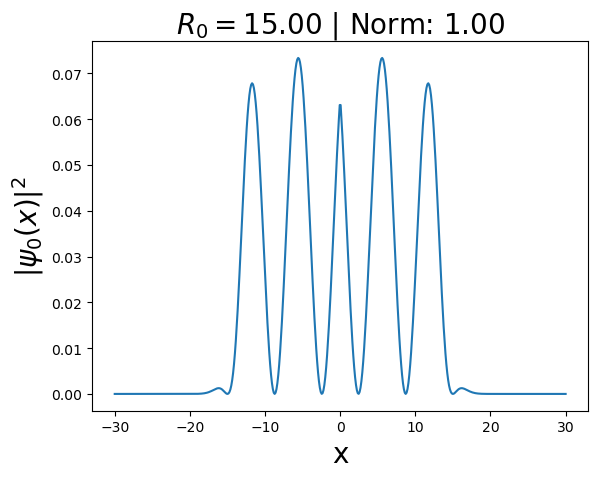

In [ ]:
#| code-fold: true
FontSize = 20
plt.title(r"$R_0 = $" + "{:2.2f}".format(R0) + " | Norm: " + "{:2.2f}".format(norm), fontsize = FontSize)
plt.plot(x, rho_GS)
plt.xlabel("x", fontsize = FontSize)
plt.ylabel(r"$|\psi_0(x)|^2$", fontsize = FontSize)
print()

## 1.2 - Different parameters

Now that you have solved the task, repeat the whole process for $R_0=1, 2, 5$ and $20$. Considering also the previously obtained results for $R_0=10$, what conclusions can you draw?
 
## 1.3 - Consider different profiles

Finally, we have enforced a specific wave function profile $f(x) = \frac{\sin(x/2)}{1+e^{-x}}$. Repeat the calculation from **1.1** with a different profile: $f(x) = \frac{\sin(x)}{1+e^{-x}}$.


# 2 - Hamiltonian learning

Hamiltonian learning is one of the most important problems in many-body quantum physics, specially from an experimental point of view. The goal is to extract the Hamiltonian parameters from experimental observations. Thus, this problem can be naturally framed as a regression task in machine learning.

## Spin Hamiltonian in one-dimension

As an example let us consider one-dimensional spin chain of length $L$ given by the general Heisenberg Hamiltonian:

\begin{equation}
 \hat{H} = \sum_j J_x \hat{S}^x_j\hat{S}^x_{j+1} + J_y\hat{S}^y_j\hat{S}^y_{j+1} + J_z\hat{S}^z_j\hat{S}^z_{j+1} + h\sum_j \hat{S}^z_j,
\end{equation}
where each spin operator is $\hat{S}^\tau_j = \frac{1}{2}\hat{\sigma}^\tau_j$, $\hat{\sigma}^\tau$ are Pauli operators with $\tau = \{x,y,z\}$ and
\begin{equation}
\hat{\sigma}^\tau_j = \mathbb{1}^{j-1}\otimes\hat{\sigma}^\tau\otimes\mathbb{1}^{L-j}\,.
\end{equation}

## Magnetization dynamics

Let us consider an example from the work by Kushal Seetharam, et. al. [Digital quantum simulation of NMR experiments](https://arxiv.org/abs/2109.13298), where they study Nuclear Magnetic Resonance (NMR).

We are interested in the change in time of the total spin magnetization:
\begin{equation}
S(t) = \langle \psi_0 |\hat{U}^\dagger(t)\hat{S}^z_{\rm total} \hat{U}(t)|\psi_0\rangle\,,
\end{equation}
where $\hat{U}(t) = e^{-i\hat{H} t}$ is the time evolution operator.

We assumed that the initial state $|\psi_0\rangle$ is a superposition of states with different total magnetization $m_i$, i.e. 
\begin{equation}
|\psi_0\rangle = \frac{1}{{\cal N}}\sum_{m_i>0} m_i|m_i\rangle,
\end{equation}
where ${\cal N}$ is a normalization constant, $\{m_i, |m_i\rangle\}$ are eigenvalues and eigenstates of the total $\hat{S}^z_{\rm total}$ operator. Thus,
\begin{align}
 \hat{S}^z_{\rm total} & = \sum_{j} \hat{S}^z_j\,, \\
 \hat{S}^z_{\rm total} |m_i\rangle & = m_i |m_i\rangle\,.\\
\end{align}

Such an assumption about the initial state can be motivated by the fact that spins are not in the ground state of the Hamiltonian. They are rather in a superposition of different magnetization states due to a relatively 'high' temperature of the spins.

## The task

The magnetization through time $S(t)$ depends on the value of the Hamiltonian parameters, i.e., $y = [J_x, J_y, J_z, h]$. Your task is to train a neural network to extract these parameters based on the provided signal $S(t)$.

However, when we consider time-dependent data, it is more favorable to work with its Fourier Transform, $FFT[S(t)]$, or the related power spectrum $PS = |FFT[S(t)]|^2$. As such, the task is to infer $[J_x, J_y, J_z, h]$ from the $PS$. For simplicity, we will assume $J_x = J_y = J_z = J$.

## Data generation

The first thing we need is to generate a suitable datast to train our machine learning model. We provide the code to generate the data below. However, generating proper dataset could be computationally demanding, so you don't have to do it yourself, and you can downloaded prepared dataset from [here](https://drive.google.com/file/d/15b50pFXZEuhJWh3aH7lOMEN9LGpaJvWL/view?usp=share_link).

Explore the data and its format. The dataset is comprised of $20^4$ tuples $\{x, y\} = \{PS, [J_x, J_y, J_z, h]\}$ obtained for $L = 6$ spins, and $J_x, J_y, J_z, h \in [-2, 2]$. The total time evolution was $t_{\rm max} = 5$, with $N_t = 200$ time discretization points. As such, the PS is a vector with $N_t$ entries.

In [ ]:
# Pauli operators
id_local = pt.tensor([[1.,0],[0,1.]]) + 0*1j
sigma_x = pt.tensor([[0,1.],[1.,0]]) + 0*1j   
sigma_y = 1j*pt.tensor([[0,-1.],[1.,0]]) + 0*1j
sigma_z = pt.tensor([[1.,0],[0,-1.]]) + 0*1j

# spin-1/2 operators
s_x = 0.5*sigma_x 
s_y = 0.5*sigma_y
s_z = 0.5*sigma_z 


def get_Identity(k):  # returns k-tensor product of the identity operator, ie. Id^k
    Id = id_local
    for i in range(0, k-1):
        Id = pt.kron(Id, id_local)
    return Id
         
def get_hamiltonian_H(parameters):
    D = 2**L
    # Quantum Heisenberg model
    H = pt.zeros((D,D)) 
    J = parameters[0]
    h  = parameters[1]
    for i in range(1,L):
        H = H + J*(Sx[i]@Sx[i+1] + Sy[i]@Sy[i+1] + Sz[i]@Sz[i+1])
    for i in range(1,L+1):
        H = H + h*Sz[i]
    return H

def get_string_operator(A, L, i):
    Op = A
    if(i == 1):
        Op = pt.kron(A,get_Identity(L-1))
        return Op
    if(i == L):
        Op = pt.kron(get_Identity(L-1),A)
        return Op
    if(i>1 and i<L):
        Op = pt.kron(get_Identity(i-1), pt.kron(Op, get_Identity(L-i)))
        return Op

Let's see how the $PS$ behaves differently depending on the Hamiltonian parameters for $L = 6$ spins.

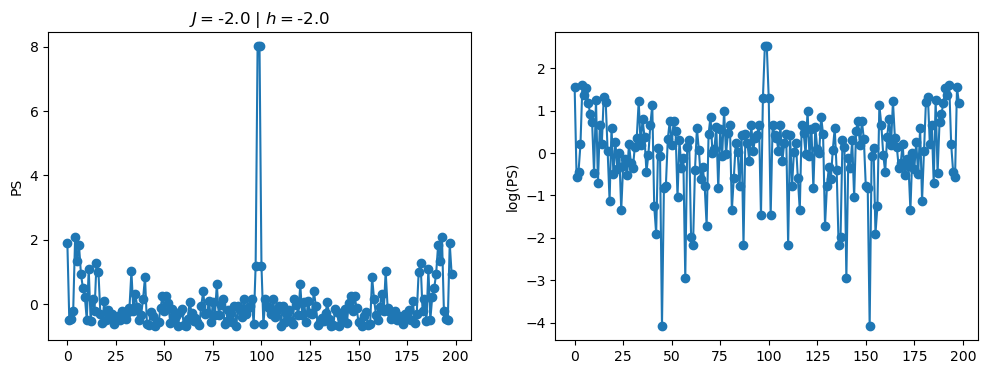

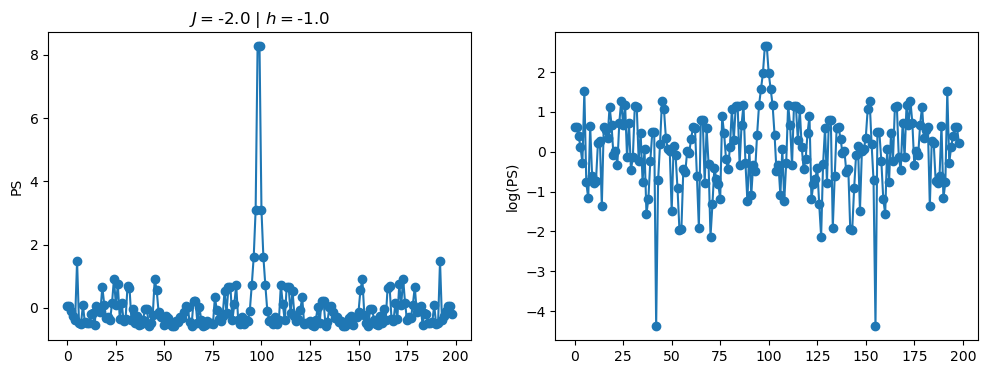

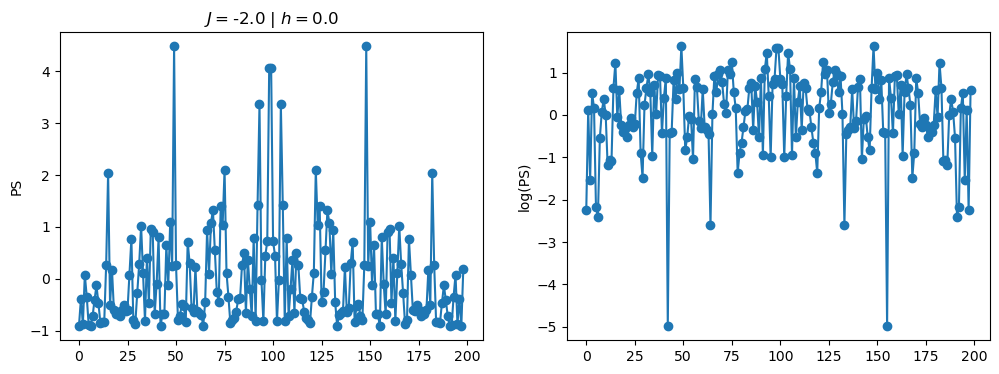

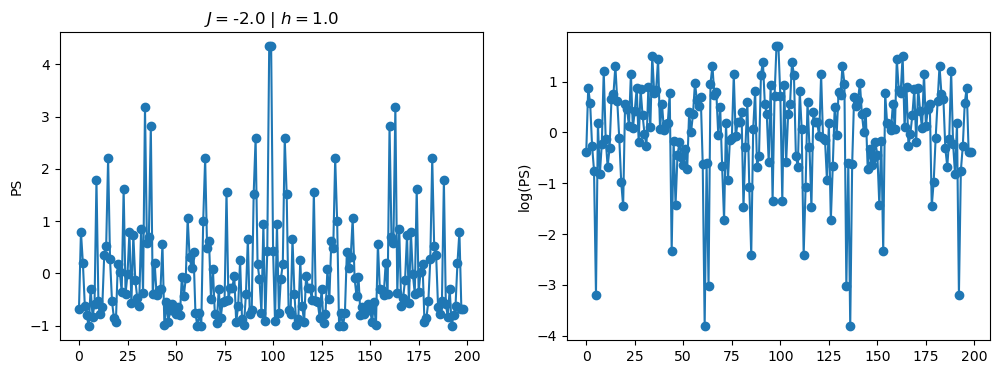

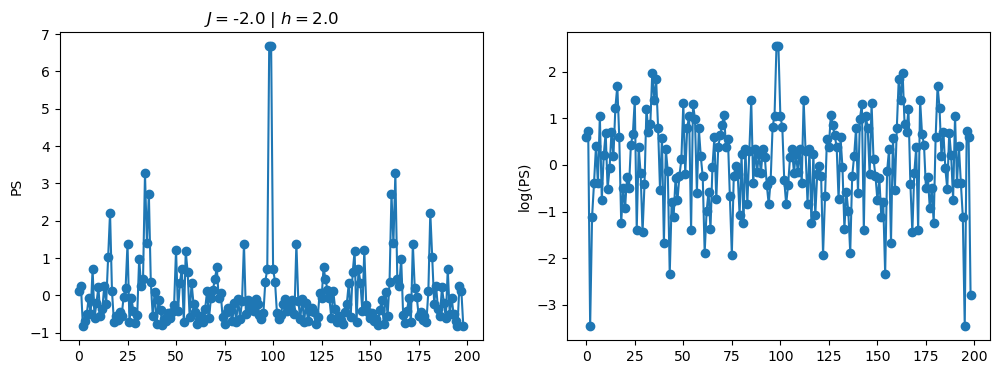

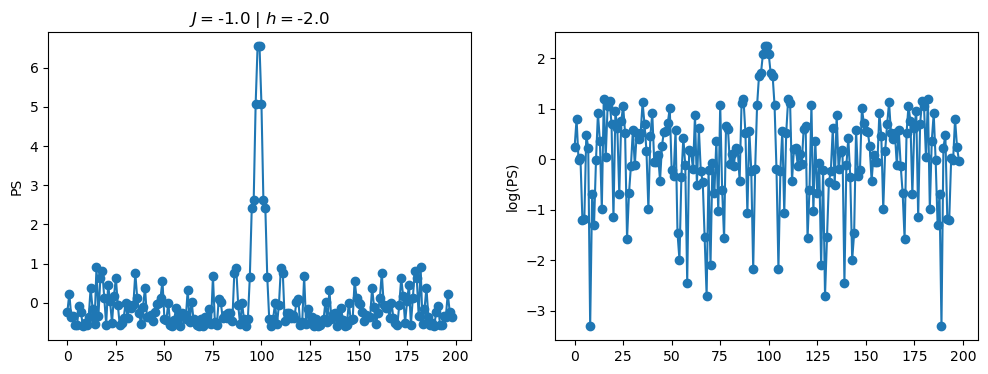

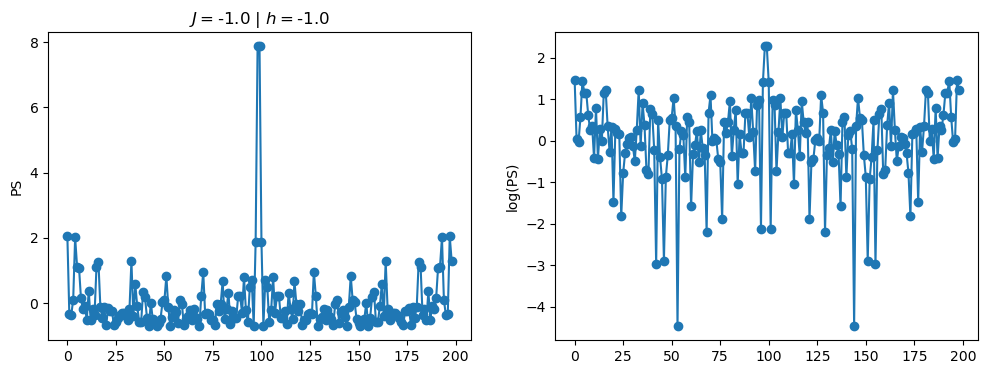

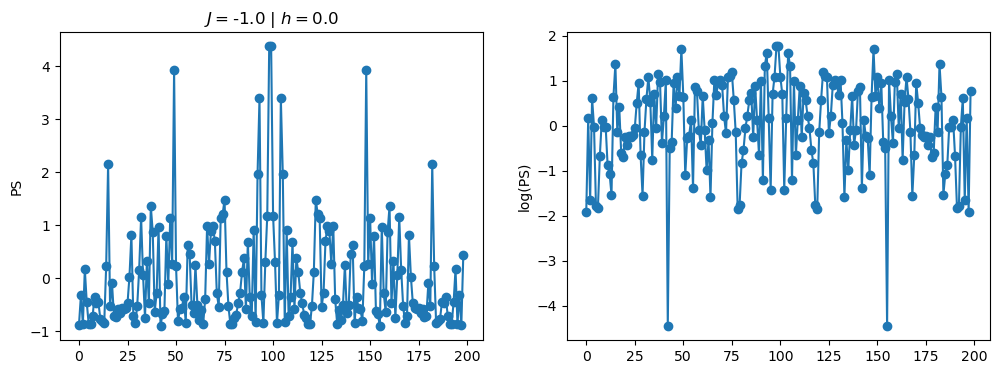

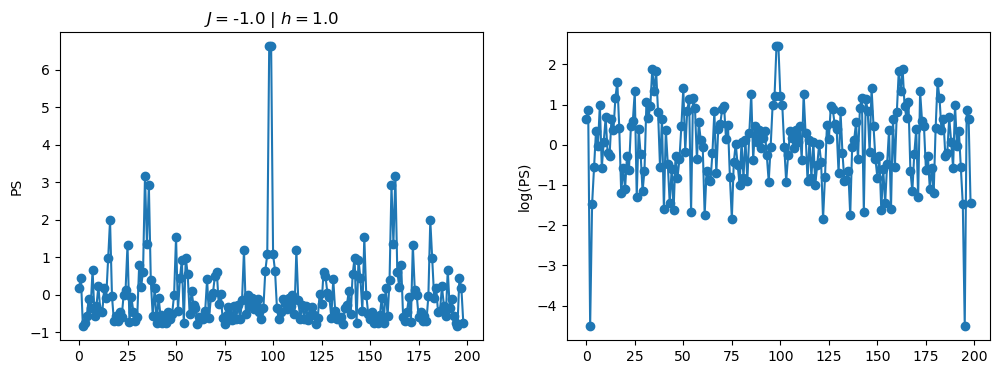

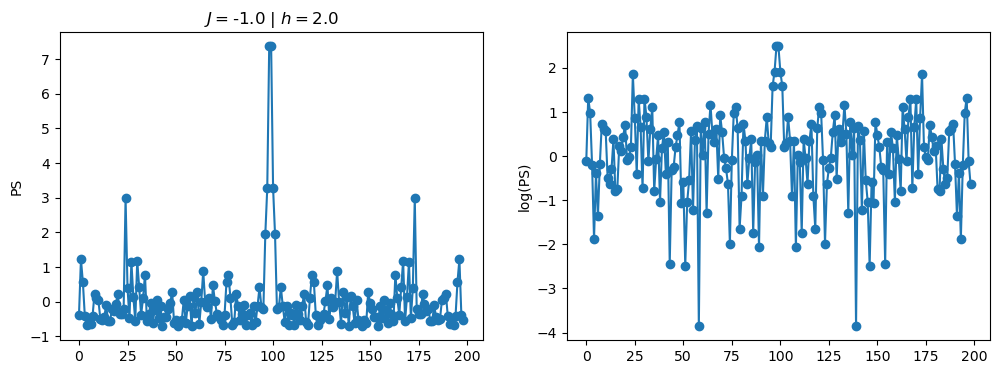

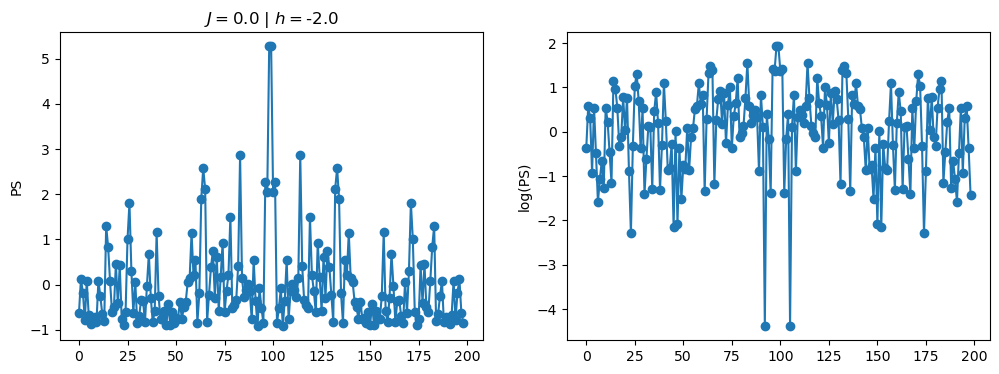

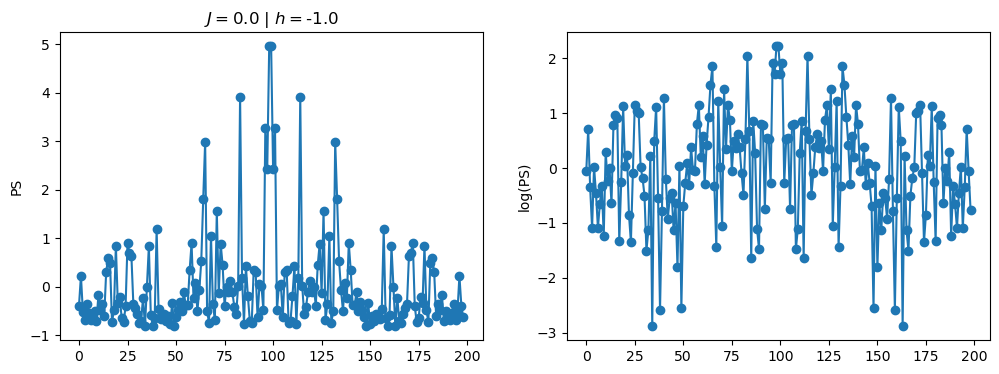

/tmp/ipykernel_230546/3124271572.py:122: RuntimeWarning: divide by zero encountered in log
  log_PS = np.log(PS)
/tmp/ipykernel_230546/3124271572.py:123: RuntimeWarning: invalid value encountered in subtract
  normalized_logPS = (log_PS - np.mean(log_PS))/np.std(log_PS)


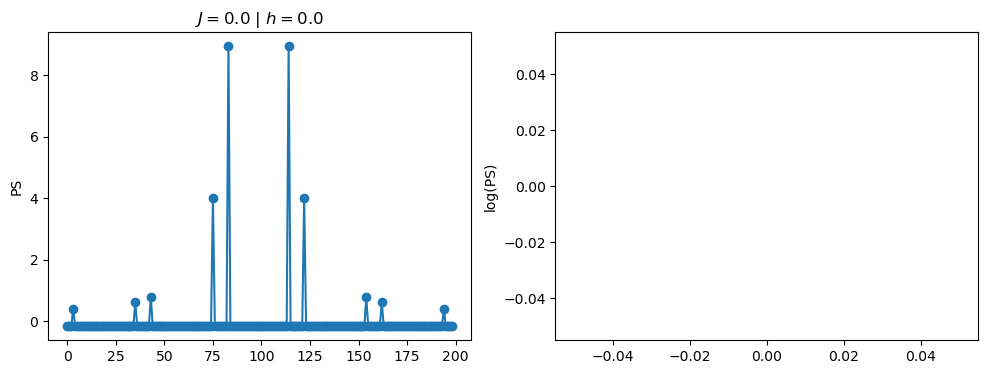

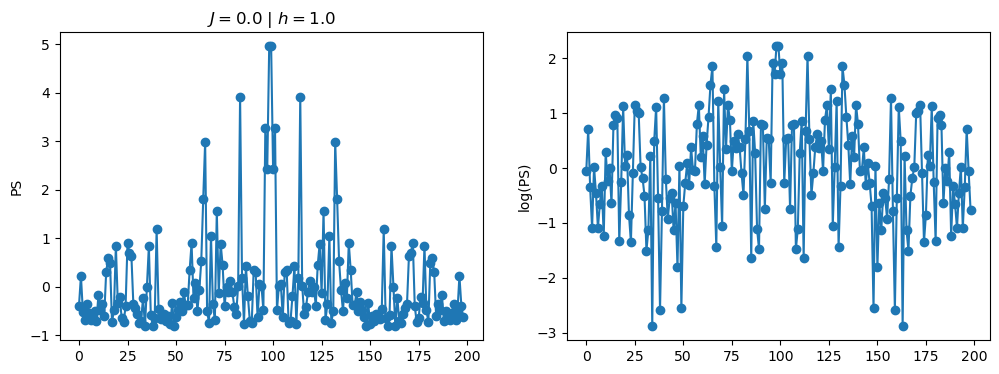

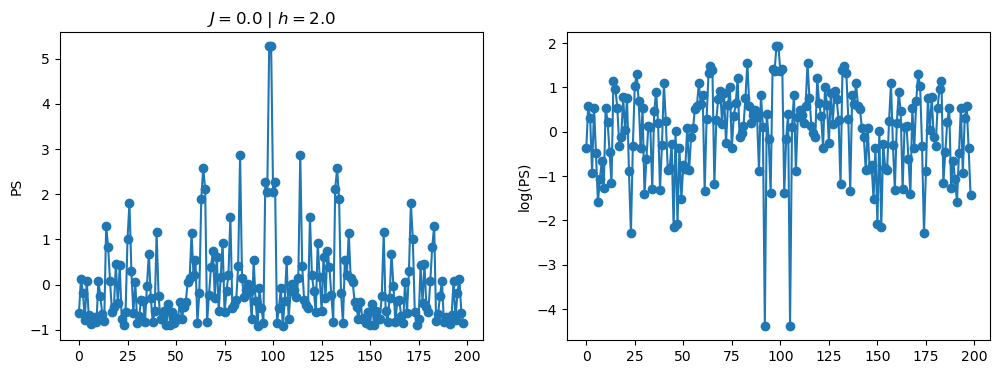

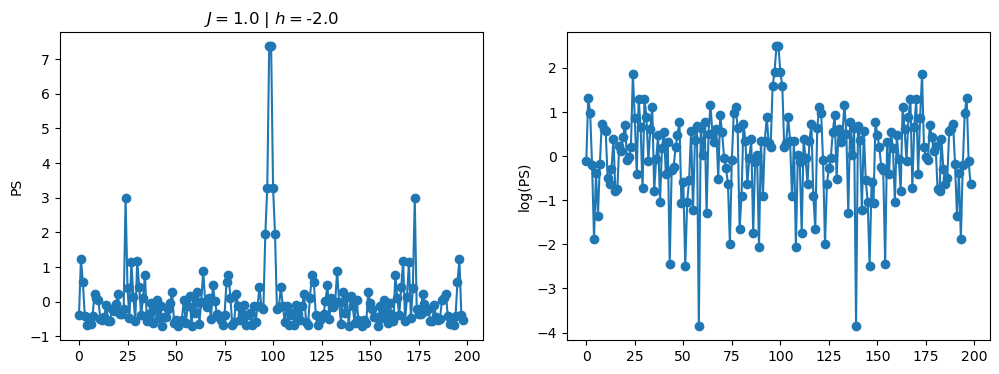

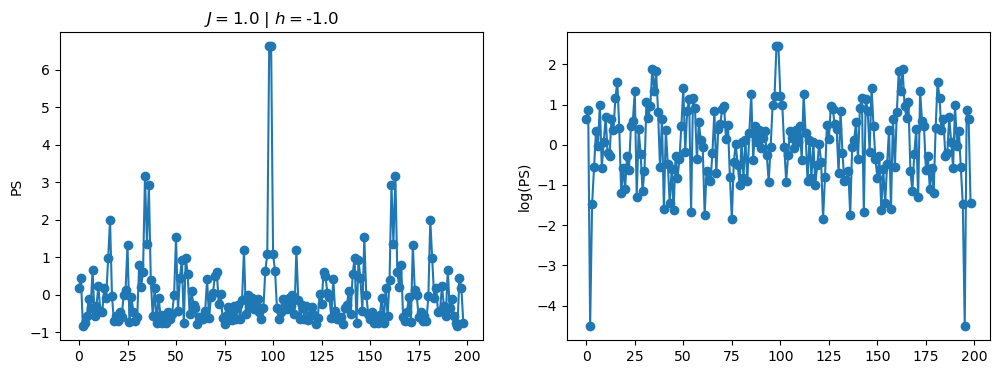

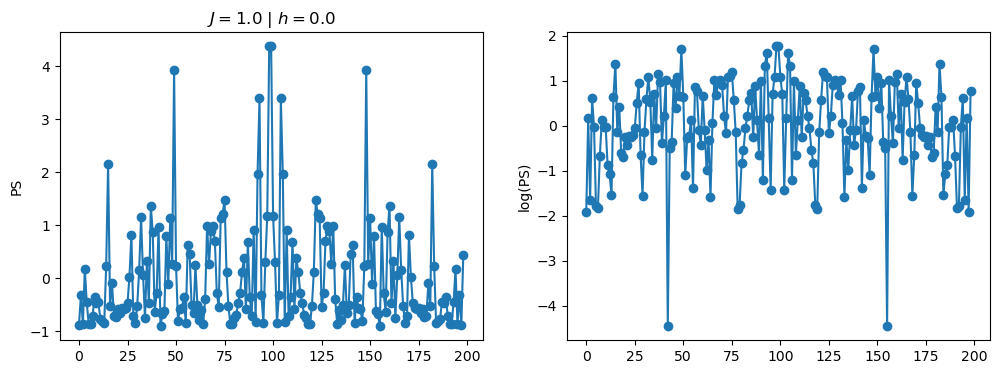

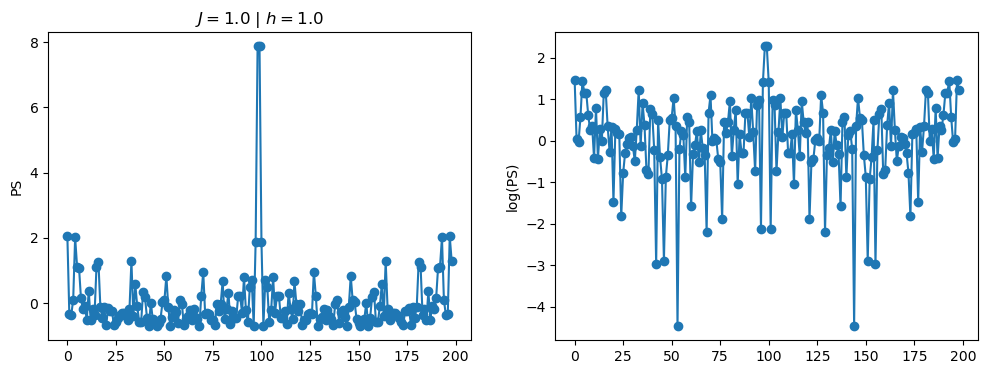

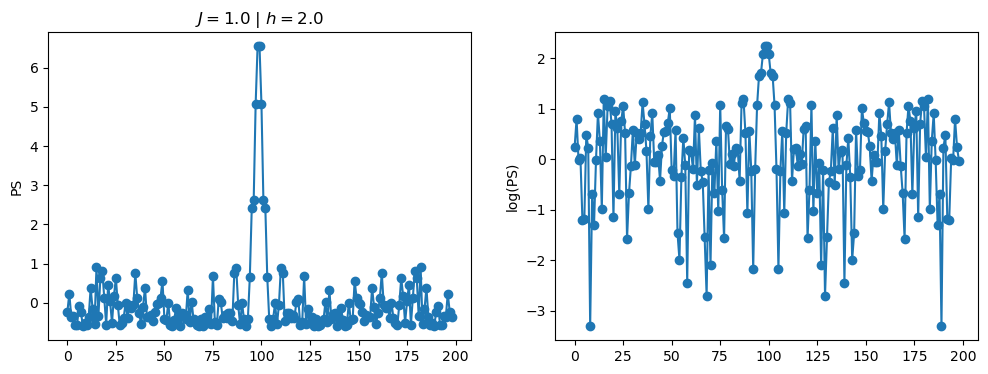

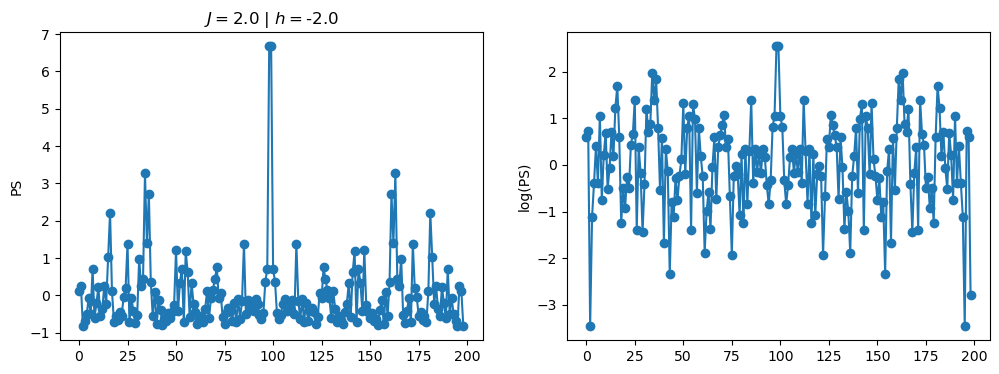

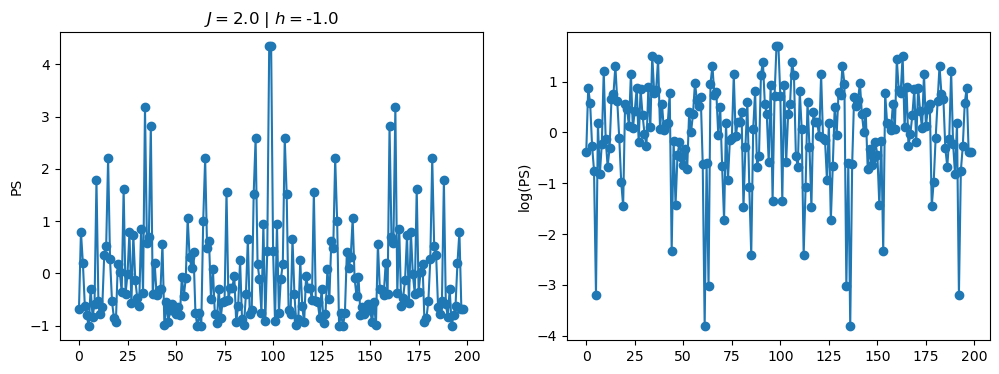

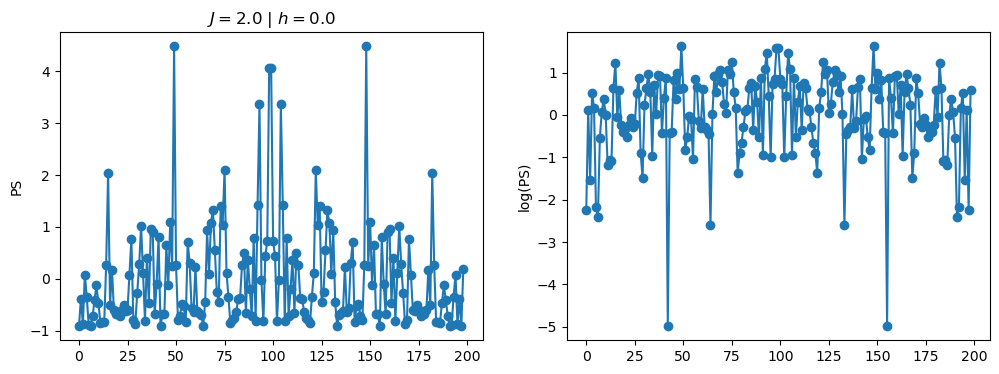

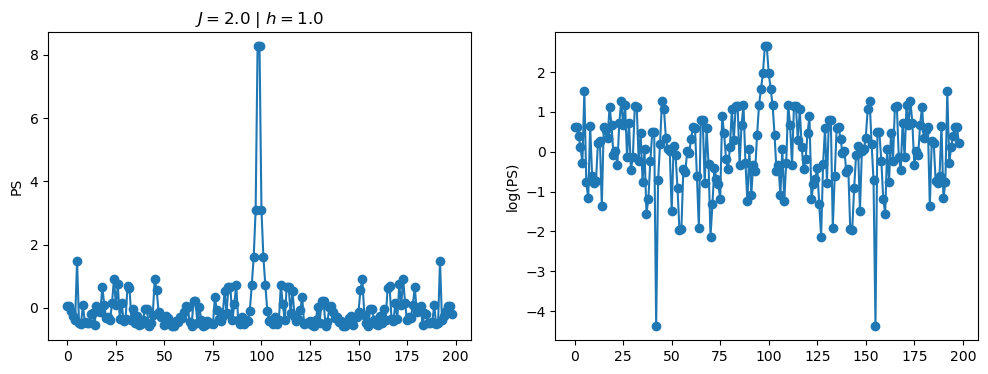

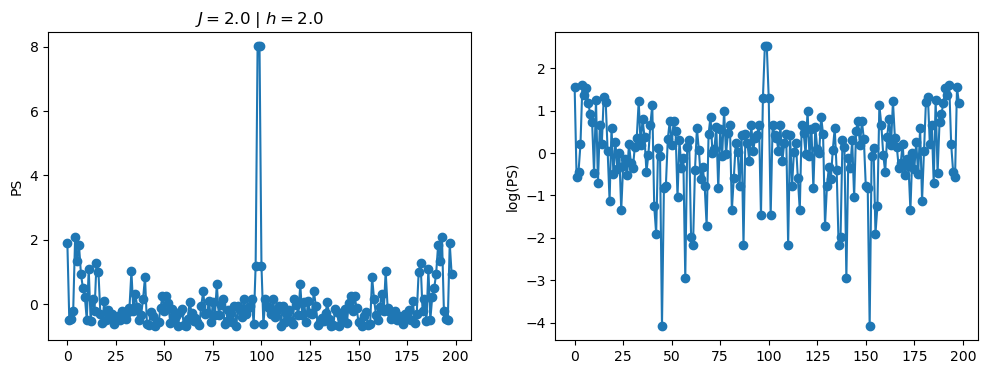

In [ ]:
#| code-fold: true
L_vec = [6]

J_vec = np.array([-2, -1, 0, 1, 2])
h_vec = np.array([-2, -1, 0, 1, 2])
 
N_total = J_vec.shape[0]*h_vec.shape[0]

for L in L_vec:   
    D = 2**L
    # Operators acting on j-th spin in spin chain
    Sigmax = {}
    Sigmay = {}
    Sigmaz = {}

    Sx = {}
    Sy = {}
    Sz = {}
    
    for j in range(1,L+1):
        index = j
        Sigmax[index] = get_string_operator(sigma_x, L, j)
        Sigmay[index] = get_string_operator(sigma_y, L, j)
        Sigmaz[index] = get_string_operator(sigma_z, L, j)
        Sx[index] = get_string_operator(s_x, L, j)
        Sy[index] = get_string_operator(s_y, L, j)
        Sz[index] = get_string_operator(s_z, L, j)
 
    Sx_total = sum(Sx[i] for i in range(1,L+1))
    Sy_total = sum(Sy[i] for i in range(1,L+1))
    Sz_total = sum(Sz[i] for i in range(1,L+1))    
       
    # Prepare initial state as a linear combination of all eigenstates of Sz_total operator
    Sz_eval, Sz_evec = eigh(Sz_total)
    psi_0 = pt.zeros(D) + 1j*0
    for i in range(0,D):
        if(Sz_eval[i] > 0):
            psi_0 = psi_0 + Sz_eval[i]*Sz_evec[:,i]
    norm = pt.sum(pt.abs(psi_0)**2)
    psi_0 = psi_0/pt.sqrt(norm)
    
    data = []
    data_x_y = []
    counter = 0
    
    # Data generation
    for (J_i, J) in enumerate(J_vec):
        for (h_i, h) in enumerate(h_vec):
            counter = counter + 1                
            parameters_H = np.array([J, h])
            H = get_hamiltonian_H(parameters_H)
            N_t = 200
            t_max = 5
            t_vec = pt.linspace(0,t_max, N_t)

            # Calculate time-evolution of the expectation value of the Sz_total
            Sz_total_val = pt.zeros(N_t)
            for (t_i,t) in enumerate(t_vec):                         
                U_t = expm(-1j*t*H)               # contruct time-evolution operator for Hamiltonian
                U_t_dag = expm(1j*t*H)            # and its complex conjugate
                Sz_total_t = U_t_dag@Sz_total@U_t # 
                Sz_total_val[t_i] = pt.vdot(psi_0, Sz_total_t@psi_0) # calculate <S^z_total(t)> 

            # Calculate and process Fourier Transform of time signal S(t)
            FFT_Sz_total_val = np.fft.fft(Sz_total_val)                 # get Fast Fourier Transform
            FFT_Sz_total_val = FFT_Sz_total_val[1:]                     # remove 0-frequency peak
            FFT_Sz_total_val = np.fft.fftshift(FFT_Sz_total_val)        # center the spectrum
            PS = np.abs(FFT_Sz_total_val)**2                            # calculate power spectrum  
            normalized_PS = (PS - np.mean(PS))/np.std(PS)               # normalize ps

            log_PS = np.log(PS)
            normalized_logPS = (log_PS - np.mean(log_PS))/np.std(log_PS)

            title_string = r"$J = $" + "{:2.1f}".format(J)
            title_string = title_string + r" | $h = $" + "{:2.1f}".format(h)
            fig, ax = plt.subplots(1,2, figsize = (12,4))
            ax[0].plot(normalized_PS,'-o')
            ax[1].plot(normalized_logPS,'-o')    
            ax[0].set_ylabel("PS")
            ax[1].set_ylabel("log(PS)")
            ax[0].set_title(title_string)
            plt.show()             


## 2.1 - Data preprocessing

As an input for the neural network, we can consider either the power spectrum $PS = |FFT[S(t)]|^2$, or its logarithm $\log(PS)$. Furthermore, we usualy also normalize the input data to zero mean, and unit standard deviation. We achieve this with the normalization:
\begin{equation}
  x \leftarrow \frac{x - {\rm mean}(x)}{{\rm std}(x)}.
\end{equation}

Pre-process the data and split it into a training and a test set. For now, consider the normalized logarithm of the power spectrum.

## 2.2 - Train the model

Train a neural network with $N_t$ input and 2 output neurons, which correspond to $[J, h]$. Consider 0, 1 and 2 hidden layers with 500 neurons. Use the MSE loss to train and report it for the training and test sets. What conclusions can you extract? Is the network overfitting the data?

::: {.callout-note}
Don't worry about the poor performance of the neural network. Hamiltonian learning is a hard task - this is just to get a flavour of an application of machine learning to quantum many-body physics.
:::

## 2.3 - Regularization

Take the best performing model and experiment with dropout. First, add dropout with 0.2 and 0.5 before the last layer. Then, add dropout only to the input layer with the same values. What differences do you observe? Does the model improve? Where is it more effective?

Finally, add dropout to both layers and compare with the obtained results.

## 2.4 - Input data

Now let's take the best performing architecture and train it with the normalized power spectrum (we have used the logarithm so far). What differences can we observe with respect to training with the logarithm?

::: {.callout-tip}

Use the code below as a guideline to complete the tasks.
:::

In [ ]:
# import torch as pt
# from torch.utils.data import Dataset, DataLoader, random_split
# from torch.utils.data.sampler import SubsetRandomSampler
# import torch.optim as optim
# import torch.nn as nn

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

Reading data from file, preparing train/test datasets and preparing train/test PyTorch DataLoader:

In [ ]:
# from torch.utils.data import Dataset, DataLoader, random_split
# from torch.utils.data.sampler import SubsetRandomSampler
# import torch.optim as optim
# import torch.nn as nn

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# class CustomDataset(Dataset):
#     def __init__(self, x, y):
#         self.x = x
#         self.y = y
    
#     def __len__(self):
#         return len(self.y)
    
#     def __getitem__(self, index):
#         y = self.y[index]
#         x = self.x[index]
#         return x, y
    
# # Read data from pandas dataframe, prepare train/test data sets and train/test data loaders
# np.random.seed(0)
# pt.manual_seed(0)
# df = pd.read_pickle("Hamiltonian_learning_data.pkl")

# # split datafram into train and test datasets
# N_train = int(0.7*len(df))
# N_test  = int(0.3*len(df))
 
# idx_train = np.random.randint(0, len(df), N_train)
# idx_test  = np.random.randint(0, len(df), N_test)
# train_dataset = df.iloc[idx_train].reset_index()
# test_dataset  = df.iloc[idx_test].reset_index()


# train_data = CustomDataset(train_dataset['normalized_log_PS'], train_dataset['hamiltonian_parameters'])
# test_data  = CustomDataset(test_dataset['normalized_log_PS'], test_dataset['hamiltonian_parameters'])

# train_data = CustomDataset(train_dataset['normalized_PS'], train_dataset['hamiltonian_parameters'])
# test_data  = CustomDataset(test_dataset['normalized_PS'], test_dataset['hamiltonian_parameters'])



# # build DataLoaders
# BatchSize = 1024
# train_loader = DataLoader(train_data, batch_size = BatchSize, shuffle=True)
# test_loader  = DataLoader(test_data , batch_size = BatchSize, shuffle=True)

Define neural network model, loss function and optimizer:

In [ ]:
# # Build neural network
# N_t = 199
# h_1 = 500
# h_2 = 250
# h_3 = 125
# output_layer = 2

# model = nn.Sequential(
#           nn.Linear(N_t,h_1),
#           nn.ReLU(),
#           nn.Linear(h_1, h_2),
#           nn.BatchNorm1d(h_2),
#           nn.ReLU(),
#           nn.Linear(h_2, h_3),
#           nn.BatchNorm1d(h_3),
#           nn.ReLU(),         
#           nn.Dropout(0.5), # Careful with dropout, follow the instructions!
#           nn.Linear(h_3, output_layer)
#         )

# model.double()

# # Define the loss function and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=.1)

Training pipeline:

In [ ]:
# N_epochs = 1000

# # Training loop
# loss_vs_epoch = []
# for epoch in range(0, N_epochs):
#     running_loss = 0.0
#     for x, y in train_loader:
 
#         # Clear the gradients
#         optimizer.zero_grad()
                
            
#         # Forward pass
#         y_pred = model(x)
        
#         # Calculate the loss
#         loss = criterion(y_pred, y)        

#         # Backward pass
#         loss.backward()  # automatic calculating the loss with respects to trainable parameters
        
#         # Update the weights according to chosen optimization function. Here: Adam
#         optimizer.step()
        
#         # Print statistics
#         running_loss += loss.item()
#     loss_vs_epoch.append(running_loss)
#     print(f"Epoch {epoch} - Training loss: {running_loss/len(train_loader)}")